# Import Libraries

In [ ]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import warnings
import sys
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import orient
import pathlib
import requests
import numpy as np
import pandas as pd
import requests
import gzip
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
import sys
sys.path.append('src')
from well_pump import geojson_to_lonlat_lists

## Import api key

store api in a file named ".env"

In [3]:
load_dotenv()
api_key = os.getenv("oet-api")


# Download Experimental peff

`pou_classified.gpkg` was made using `planet_ndvi_polygons.ipynb`

In [5]:
pou = gpd.read_file("pou_oet.shp")  


In [6]:
# set your API key before making the request
header = {"Authorization": api_key}

data = {}

ind = 0
for feat in pou.itertuples():
    if ind >200:
        lonlat_lists = geojson_to_lonlat_lists(
            path="pou_classified.gpkg",
            feature_index=ind,
            include_holes=False,
            enforce_ccw=True,
            simplify_tolerance=10,
            simplify_units="meters",
        )
        
        print(f"Feature {feat.Index} lonlat lists: {lonlat_lists}")
        args = {
            "date_range": [
                "2020-01-01",
                "2025-12-31"
            ],
            "file_format": "json",
            "geometry": lonlat_lists,
            "interval": "monthly",
            "model": "Ensemble",
            "reference_et": "gridMET",
            "spinup": 12,
            "units": "mm"
            }
        request_url = "https://utah.openet-api.org/"
        # query the api 
        resp = requests.post(
            headers=header,
            json=args,
            url=request_url + "experimental/peff/polygon"
        )

        print(resp.json())
        data[feat.Index] = resp.json()
    ind += 1

Feature 201 lonlat lists: [-113.00861836285146, 38.357619511117655, -113.00973150538658, 38.357719168087286, -113.00975145916878, 38.3540996732774, -113.0051639947547, 38.3540005038377, -113.00535719665606, 38.35513142938302, -113.00604285525728, 38.356255637678416, -113.00718034119764, 38.357118434602036]
{'detail': 'Memory limit reached, too many pixels in the region.'}
Feature 202 lonlat lists: [-113.00784060653208, 38.33716613049291, -113.00767528448233, 38.33622428970586, -113.00696830007097, 38.33554049182331, -113.0057938079691, 38.33519259154416, -113.00462607057658, 38.33535201100207, -113.0055507789058, 38.33697408712843, -113.00445878801169, 38.33847723839268, -113.00563263056532, 38.338694483772954, -113.00667704009548, 38.3385148383648, -113.00748018198661, 38.337958950828565]
{'detail': 'Memory limit reached, too many pixels in the region.'}
Feature 203 lonlat lists: [-113.05724205140997, 38.29141187186174, -113.05664889483735, 38.292070535554664, -113.0564561814524, 38.2

ConnectionError: ('Connection aborted.', ConnectionAbortedError(10053, 'An established connection was aborted by the software in your host machine', None, 10053, None))

In [48]:
new_data = {}
for key,value in data.items():
    print(value[0].values())
    print(value[0].keys())
    new_data[key] = pd.DataFrame(list(value[0].values()), index=list(value[0].keys()))


dict_values(['2023-01-01', 50.628, 0.0, 1.441, 50.86])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 49.34, 0.0, 2.912, 50.645])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 50.704, 0.0, 4.991, 50.936])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 50.148, 0.0, 10.001, 50.364])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 49.841, 0.0, 4.37, 49.841])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 50.302, 0.0, 5.055, 50.525])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])


In [49]:
peff = pd.concat(new_data).unstack(-1).droplevel(0,axis=1)
peff.index.name = "obid"

In [ ]:
peff.to_csv("pou_peff_2023_2024_3.csv")

In [ ]:


# set your API key before making the request
header = {"Authorization": api_key}

# endpoint arguments
args = {
  "interval": "monthly",
  "geometry": [-113.09, 38.175, -113.09, 38.43, -112.9, 38.43, -112.9, 38.175],
  "model": "Ensemble",
  "variable": "PR",
  "reference_et": "gridMET",
  "units": "mm",
  "encrypt": False
}

years = range(1990, 2026)
for year in years:
    args["date_range"] = [f"{year}-01-01",f"{year}-12-31"]

    # query the api 
    resp = requests.post(
        headers=header,
        json=args,
        url="https://utah.openet-api.org/raster/export/stack"
    )

    print(resp.json())

{'1990-01-01': {'tracking_id': 'HVZKE7MDPVYY6C4YZCXPW7T7', 'encrypted': False, 'name': 'ddb16', 'destination': 'drive'}, '1990-02-01': {'tracking_id': '3SZSRF3E2ZZVZWRYKBDUOGZ3', 'encrypted': False, 'name': 'e3530', 'destination': 'drive'}, '1990-03-01': {'tracking_id': 'ABO5VDOI7SEQSKOQGHYJZVST', 'encrypted': False, 'name': '27e29', 'destination': 'drive'}, '1990-04-01': {'tracking_id': 'ZQIFJMNP33O5FCUNKAS5SJXM', 'encrypted': False, 'name': '30a39', 'destination': 'drive'}, '1990-05-01': {'tracking_id': 'Y47N5QXGFS2T3N7WR6NIEFDR', 'encrypted': False, 'name': '44340', 'destination': 'drive'}, '1990-06-01': {'tracking_id': 'EHN4FGKCJW3SCHKUZFSWACL5', 'encrypted': False, 'name': 'e98d0', 'destination': 'drive'}, '1990-07-01': {'tracking_id': 'FT4UQZWCLUXPOJQE3O2XQX5O', 'encrypted': False, 'name': 'd4516', 'destination': 'drive'}, '1990-08-01': {'tracking_id': '7CLZX5UOZFOL34SXBVGK7PUP', 'encrypted': False, 'name': '6df9f', 'destination': 'drive'}, '1990-09-01': {'tracking_id': 'LVFA7BHL

In [ ]:
# set your API key before making the request
header = {"Authorization": api_key}


args = {
    "date_range": [
        "1991-01-01",
        "2000-01-01"
    ],
    "interval": "monthly",
    "field_ids":oet_list,
    "models": ["ensemble"],
    "variables":["ET","PR"],
    "file_format": "json",
    }
request_url = "https://utah.openet-api.org/"
# query the api 
resp = requests.post(
    headers=header,
    json=args,
    url=request_url + "geodatabase/timeseries"
)


# Download Timeseries

## Import the GIS

Import the GIS and pull the important variables into dictionaries.

In [16]:
gdf = gpd.read_file("pou_oet.shp")
oetgdf = gdf.dropna(subset=['field_id']).set_index('field_id')
oetgdf.index = oetgdf.index.astype(int)
oet_list = oetgdf.index.astype('int').astype("str").tolist()
areas = np.round(oetgdf.geometry.area * 0.000247105,1).to_dict()
grpnb = oetgdf['GROUP_NUMB'].to_dict()
oetgdf['tot_area'] = np.round(oetgdf.geometry.area * 0.000247105,1)
totarea = oetgdf[['tot_area','GROUP_NUMB']].groupby(['GROUP_NUMB']).sum().to_dict()

## Pull Data from OpenET

In [6]:
# set your API key before making the request
header = {"Authorization": api_key}


args = {
    "date_range": [
        "2020-01-01",
        "2025-12-01"
    ],
    "interval": "monthly",
    "field_ids":oet_list,
    "models": ["ensemble","eemetric","ssebop"],
    "variables":["ET","PR"],
    "file_format": "json",
    }
request_url = "https://utah.openet-api.org/"
# query the api 
resp = requests.post(
    headers=header,
    json=args,
    url=request_url + "geodatabase/timeseries"
)


## Combine openet timeseries data with pou shapefile data

In [ ]:

# unzip the data
data = eval(gzip.decompress(resp.content).decode())
db_oet = pd.DataFrame(data)
db_oet['time'] = pd.to_datetime(db_oet['time'])
db_oet['field_id'] = db_oet['field_id'].astype('int')
db_oet['et_acft'] = db_oet['value_mm'] *  db_oet['field_id'].map(areas)* 0.00328084
db_oet = db_oet.set_index(['field_id','time','collection'])
db_oet.drop(['value_mm'],axis=1,inplace=True)
db_oet = db_oet.unstack('collection').droplevel(0,axis=1)
db_oet['GROUP_NUM'] = db_oet.index.get_level_values(0).map(grpnb)
#db_oet.to_csv("pou_oet_2020_2025_3.csv")

# Calculate field totals and Net ET (consumptive use)

In [31]:
# assume df has a MultiIndex with names ("fieldid", "date")
fid = db_oet.index.get_level_values("field_id")
dt  = db_oet.index.get_level_values('time')

# keep only March (3) through November (11)
mask = (dt.month >= 3) & (dt.month <= 11)
df_mn = db_oet[mask]

# group by fieldid and calendar year
out = (df_mn
       .groupby([fid[mask], dt[mask].year]).sum())


out.index.names = ["field_id", "year"]

out['eff_et_ens'] = out['ensemble_et'] - out['gridmet_pr']
out['eff_et_eem'] = out['eemetric_et'] - out['gridmet_pr']
out['eff_et_ens'] = out['ssebop_et'] - out['gridmet_pr']
ef_df = out['eff_et_ens'].unstack(level=-1)
ef_df.columns = [f'efet_{col}' for col in ef_df.columns]
ef_df.index = ef_df.index.astype('int')
ef_df.index.name = 'field_id'
#ef_df = ef_df.round(1)
gdf_fid = gdf.dropna(subset=['field_id'])
gdf_fid['field_id'] = gdf_fid['field_id'].astype('int')
fld_id = pd.merge(gdf_fid.dissolve(by='field_id'),
                  ef_df,left_index=True,right_index=True)
fld_id.to_file("field_Id_eff_et_2020_2025.gpkg")
#ef_df.to_file("Eff_ET.gpkg")

c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# assume df has a MultiIndex with names ("fieldid", "date")
fid = db_oet["GROUP_NUM"]
dt  = db_oet.index.get_level_values('time')

# keep only March (3) through November (11)
mask = (dt.month >= 3) & (dt.month <= 11)
df_mn = db_oet[mask]

# group by fieldid and calendar year
out = (df_mn
       .groupby([fid[mask], dt[mask].year]).sum())


out.index.names = ["GROUP_NUM", "year"]

out['eff_et_ens'] = out['ensemble_et'] - out['gridmet_pr']
out['eff_et_eem'] = out['eemetric_et'] - out['gridmet_pr']
out['eff_et_ens'] = out['ssebop_et'] - out['gridmet_pr']
ef_df = out['eff_et_ens'].unstack(level=-1)
ef_df.columns = [f'efet_{col}' for col in ef_df.columns]
#ef_df = ef_df.round(1)
ef_df.to_file("Eff_ET.gpkg")



In [17]:
ef_df['area'] = ef_df.index.map(totarea)

In [29]:
crp_map = gpd.read_file("pou_classified.gpkg")
crp_map = crp_map.set_index('GROUP_NUMB')
crp_map = crp_map[['ACRES', 
         'WaterSourc',
         'type', 
         'num_cuts', 
         'peak_ndvi',
         'median_ndvi', 
         'peak_date', 
         'early_med', 
         'late_med', 
         ]].rename(columns={'early_med':'early_ndvi','late_med':'late_ndvi'})
crp_map['watering_days'] = (183 - crp_map['num_cuts']*5)
crp_map = crp_map.groupby(level=0).agg({'ACRES':'sum',
                                        'type':'first',
                                        'watering_days':'mean',
                                        'WaterSourc':'first',
                                        'num_cuts':'median',
                                        'peak_ndvi':'max',
                                        'median_ndvi':'median',
                                        'peak_date':'first',
                                        'early_ndvi':'max',
                                        'late_ndvi':'max'
                                        })

fields = pd.concat([crp_map, ef_df],axis=1).round(2).drop('area',axis=1)
fields.index.name = 'GROUP_NUMB'
fields.to_csv('fields_by_groupnumb.csv')

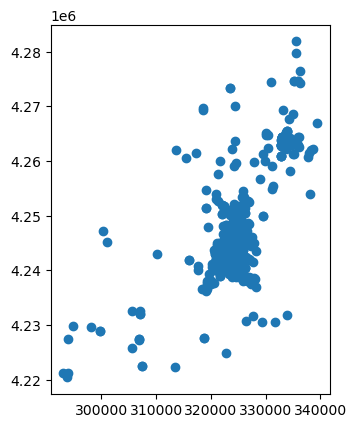

In [13]:
wells = gpd.read_file('wells_ndvi.gpkg')
wells.plot()

wells_efet = pd.merge(wells,ef_df.reset_index(),left_on='GROUP_NUMB', right_on='GROUP_NUM')

well_counts = wells_efet.groupby("GROUP_NUMB").size().reset_index(name="well_count")

for col in wells_efet.columns:
    if "etet" in col:
        wells_efet[col] = wells_efet[col] / well_counts

In [16]:
wells_efet.to_file('wells_w_efet.gpkg')
wells_efet.to_csv('wells_w_efet.csv')